In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple
from tqdm import tqdm
import seaborn as sns

To-do
- [x] Load in activitiy coefficients from test predictions
- [x] Download corresponding antoine coefficients


In [8]:
# Read in test data
test_df = pd.read_csv("../data/05_model_input/cosmo/test_indp.csv")
print(test_df.shape)
test_df_features = pd.read_csv("../data/05_model_input/cosmo/test_indp_features.csv")
test_df = pd.concat([test_df, test_df_features], axis=1)
test_df_pred = pd.read_csv("../data/07_model_output/cosmo/DG-TLCB_test_indp_preds.csv")
test_df_pred = test_df_pred[["ln_gamma_1", "ln_gamma_2"]]
test_df_pred = test_df_pred.rename(lambda x: x + "_pred", axis=1)
test_df = pd.concat([test_df, test_df_pred], axis=1)
for i in range(1, 3):
    test_df["error"]  = (test_df[f"ln_gamma_{i}"] - test_df[f"ln_gamma_{i}_pred"]).abs()
    test_df[f"gamma_{i}"] = np.exp(test_df[f"ln_gamma_{i}"])
    test_df[f"gamma_{i}_pred"] = np.exp(test_df[f"ln_gamma_{i}_pred"])
test_df_grouped = test_df.groupby(by=["cas_number_1", "cas_number_2"]).mean().reset_index()
test_df_grouped = test_df_grouped[["cas_number_1", "cas_number_2", "error"]]
print(test_df.shape)
test_df.columns

(579458, 8)
(579458, 17)


/var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_3692/497253823.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_df_grouped = test_df.groupby(by=["cas_number_1", "cas_number_2"]).mean().reset_index()


Index(['smiles_1', 'smiles_2', 'ln_gamma_1', 'ln_gamma_2', 'cas_number_1',
       'cas_number_2', 'names_1', 'names_2', 'temperature (K)', 'x(1)',
       'ln_gamma_1_pred', 'ln_gamma_2_pred', 'error', 'gamma_1',
       'gamma_1_pred', 'gamma_2', 'gamma_2_pred'],
      dtype='object')

In [3]:
# Import get function from requests module because is the function in charge of
# getting the HTTP GET request with the given url.
from requests import get

# Import BeautifulSoup from bs4 because make the html parse and help us to
# handle de DOM.
from bs4 import BeautifulSoup

# Import closing for ensure that any network resource will free when they go out
# of scope.
from contextlib import closing

import urllib.parse
import re

def get_antoine_coef(cas_number, temperatures):

    """ Return a list with the coefficients A, B and C if they exist for the
        given Temperature. If not, return None and print it.
    :param Name:
        A string with the name of the compound in English.
    :param Temperature:
        A float number with the temperature in Kelvin.
    :rtype: List
    :return coef with [A, B, C]
    """

    # Obtaining the table using the get_html function showed below. Table is a
    # BeautifulSoup Object.
    table = get_html_table(cas_number)

    # Extract the rows from the table. Knowing what tags have an HTML table.
    # Also, knowing that the fist row with he table header does not have the
    # class attribute 'exp' so we obtain just the rows with data.
    # The find_all function from BeautifulSoup return a list
    try:
        rows = table.find_all('tr', class_='exp')
    except AttributeError:
        for _ in range(len(temperatures)):
            yield [None, None, None]
        return

    # Declaring the lists for storage Temperatures, and coefficients.
    Temperatures_range, As, Bs, Cs = [], [], [], []

    # Looping over rows to extract and fill As, Bs, and Cs variables because now
    # we are sure the Temperatues is between some range.
    for row in rows:

        # As the rows, we extract the columns for the current row. Knowing that
        # the cols have the <td> tag in HTML as well
        # The find_all function from BeautifulSoup return a list
        cols =  row.find_all('td')

        # Remote uncertainty
        clean = lambda text: float(re.split(r"±\s+[\d\.\w]+", text)[0])
        # for i in range(len(cols)):
        #     res = re.split(r"±\s+[\d\.\w]+", cols[i].text)
        #     cols[i].text = res[0]

        # First transform the strings into float numbers and put them in their
        # respective list
        As.append(clean(cols[1].text))
        Bs.append(clean(cols[2].text))
        Cs.append(clean(cols[3].text))

        # For the temperatures, we have a range and we need to extract each
        # limit (lower and higher) and put them in an extra list. So
        # Temperatures variable will be a list of lists.
        lower_lim = float(cols[0].text.replace(" ","").split('-')[0])
        higher_lim = float(cols[0].text.replace(" ","").split('-')[1])
        Temperatures_range.append([lower_lim, higher_lim])


    # Checking if the Temperature gave fits in some interval
    index = None
    for temperature in temperatures:
        for i, interval in enumerate(Temperatures_range):
            if (interval[0] <= temperature
                and temperature <= interval[1]):
                index = i
                break
            else:
                index = None

        if index == None:
            yield [None, None, None]
        else:
            A = As[index]
            B = Bs[index]
            C = Cs[index]
            yield [A, B, C]


def get_html_table(cas_number):

    """ Return the html already parsed using the a helper function listed below.
    :param Name:
        A string with the name of the compound in English.
    :rtype: BeautifulSoup Object
    """

    # The name parameter is part of the url. For example, if you want the
    # methane data, the url is
    # https://webbook.nist.gov/cgi/cbook.cgi?Name=methane&Mask=4.
    # Name = urllib.parse.quote(Name)
    # url = str.format('https://webbook.nist.gov/cgi/cbook.cgi?Name={0}&Mask=4', Name)
    cas_number = urllib.parse.quote(cas_number)
    url = str.format('https://webbook.nist.gov/cgi/cbook.cgi?ID={0}&Mask=4', cas_number)

    # Function to get the request made, see below.
    raw_html = get_response(url)

    # Parse the html using BeautifulSoup.
    html = BeautifulSoup(raw_html, 'html.parser')

    # Extract the table that contains the data, the table has a specific
    # attributes 'aria-label' as 'Antoine Equation Parameters'.
    table = html.find('table', attrs={'aria-label': 'Antoine Equation Parameters'})

    return table


def get_response(url):

    """ Return the raw_html for parsing later or None if can't reach the page
    :param url:
        The string for the GET request.
    :rtype: BeautifulSoup Object
    :rtype: None if can't reach the website
    """

    try: 
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None
    
    except:
        print('Not found')
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1) 


In [4]:
# Download Antoine coefficients from NIST
all_names = pd.concat([
    test_df[["cas_number_1", "temperature (K)"]].rename(columns={"cas_number_1": "cas_number"}), 
    test_df[["cas_number_2", "temperature (K)"]].rename(columns={"cas_number_2": "cas_number"})
])
all_names_grouped = all_names.drop_duplicates().groupby("cas_number")
n = all_names["cas_number"].nunique()
antoine_data = pd.DataFrame(columns=["A", "B", "C", "temperature (K)", "cas_number"])
for cas_number, data in tqdm(all_names_grouped, total=n):
    coeffs = list(get_antoine_coef(cas_number, data["temperature (K)"].values))
    coeffs = np.array(coeffs)
    coeffs = pd.DataFrame(coeffs, columns=["A", "B", "C"])
    coeffs["temperature (K)"] = data["temperature (K)"].values
    coeffs["cas_number"] = cas_number
    antoine_data = pd.concat([antoine_data, coeffs], ignore_index=True)

100%|██████████| 88/88 [00:48<00:00,  1.81it/s]


In [9]:
test_df = test_df.merge(
    antoine_data, 
    left_on=["temperature (K)", "cas_number_1"], 
    right_on=["temperature (K)", "cas_number"],
    how="left"
)
test_df = test_df.drop("cas_number", axis=1)
test_df = test_df.rename(columns={"A": "A_1", "B": "B_1", "C": "C_1"})
test_df = test_df.merge(
    antoine_data, 
    left_on=["temperature (K)", "cas_number_2"], 
    right_on=["temperature (K)", "cas_number"],
    how="left"
)
test_df = test_df.drop("cas_number", axis=1)
test_df = test_df.rename(columns={"A": "A_2", "B": "B_2", "C": "C_2"})
test_df["antoine_exists"] = test_df["A_1"].notnull() & test_df["B_1"].notnull() & test_df["C_1"].notnull() & test_df["A_2"].notnull() & test_df["B_2"].notnull() & test_df["C_2"].notnull()

In [33]:
# Rank pairs by error and only include those with Antoine data
rank_df = test_df[test_df["antoine_exists"] == True].groupby(["cas_number_1", "cas_number_2"]).mean().reset_index().sort_values("error", ascending=False)
rank_df

/var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_3692/4159330491.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rank_df = test_df[test_df["antoine_exists"] == True].groupby(["cas_number_1", "cas_number_2"]).mean().reset_index().sort_values("error", ascending=False)


,cas_number_1,cas_number_2,ln_gamma_1,ln_gamma_2,temperature (K),x(1),ln_gamma_1_pred,ln_gamma_2_pred,error,gamma_1,gamma_1_pred,gamma_2,gamma_2_pred,antoine_exists
939,75-31-0,76-05-1,-4.231838,-4.241536,317.650000,0.5,-0.025176,0.007825,4.300705,0.370285,0.988810,0.365601,1.030390,1.0
1073,75-64-9,76-05-1,-3.977493,-3.979602,329.650000,0.5,-0.056731,-0.056645,4.002219,0.375886,0.953600,0.368159,0.960693,1.0
1298,78-81-9,76-05-1,-3.707748,-3.729132,341.370000,0.5,-0.015036,0.014647,3.775889,0.376526,0.994997,0.370408,1.028110,1.0
408,355-02-2,307-34-6,-0.004265,-0.004361,363.864286,0.5,1.291208,1.416942,1.492954,0.995752,9.102333,0.995658,17.186764,1.0
659,57-55-6,75-31-0,-0.743611,-0.717558,325.150000,0.5,0.237909,0.132515,0.858841,0.615884,1.436911,0.560107,1.155303,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,107-04-0,540-84-1,0.245382,0.360377,372.150000,0.5,0.292343,0.368437,0.008840,1.316357,1.403251,1.536758,1.551497,1.0
488,464-06-2,75-30-9,0.204972,0.206942,354.150000,0.5,0.223143,0.208659,0.008675,1.250194,1.265692,1.255718,1.257079,1.0
252,110-52-1,464-06-2,0.385125,0.371262,354.150000,0.5,0.370802,0.370257,0.008454,1.609379,1.584822,1.525132,1.526451,1.0
20,106-93-4,617-78-7,0.252239,0.333584,366.150000,0.5,0.271291,0.330439,0.008084,1.327695,1.362116,1.477449,1.471130,1.0


In [ ]:
rank_df

/Users/Kobi/Documents/Research/phd_code/deep_gamma/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/Kobi/Documents/Research/phd_code/deep_gamma/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/Kobi/Documents/Research/phd_code/deep_gamma/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/Kobi/Documents/Research/phd_code/deep_gamma/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  pl

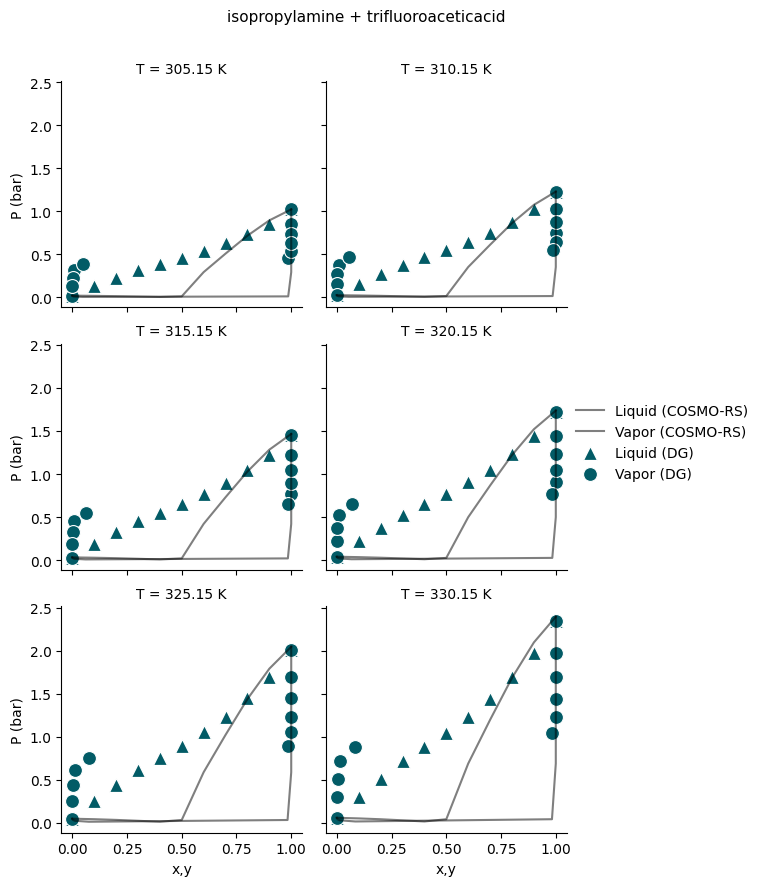

In [36]:
antoine_coefficient = namedtuple('antoine_coefficient', ['A', 'B', 'C'])

def antoine_equation(T, coefficients: antoine_coefficient):
    return 10**(coefficients.A - coefficients.B/(T + coefficients.C))

def gamma_phi_pressure(T, x, gamma_1, gamma_2, component_1_antoine, component_2_antoine):
    Psat_1  = antoine_equation(T, component_1_antoine)
    Psat_2 = antoine_equation(T, component_2_antoine)
    P = x*gamma_1* Psat_1 + (1-x)*gamma_2*Psat_2
    return  P

def make_pxy(data, suffix=""):
    Ps = []
    ys = []
    data = data.copy()
    antoine_cols_1 = ["A_1", "B_1", "C_1"]
    antoine_cols_2 = ["A_2", "B_2", "C_2"]
    for i in range(data.shape[0]):
        x = data["x(1)"].iloc[i]
        T = data["temperature (K)"].iloc[i]

        # Get antoine coefficients
        antoine_data_1 = data[antoine_cols_1].iloc[i].values.astype(float)
        if np.isnan(antoine_data_1).any():
            Ps.append(np.nan)
            ys.append(np.nan)
            continue
        ac_1 = antoine_coefficient(*antoine_data_1)
        
        antoine_data_2 = data[antoine_cols_2].iloc[i].values.astype(float)
        if np.isnan(antoine_data_2).any():
            Ps.append(np.nan)
            ys.append(np.nan)
            continue
        ac_2 = antoine_coefficient(*antoine_data_2)

        # Calculate compositions
        gamma_1 = data["gamma_1" + suffix].iloc[i]
        gamma_2 = data["gamma_2"+suffix].iloc[i]
        P_sys = gamma_phi_pressure(T, x, gamma_1, gamma_2, ac_1, ac_2)
        Ps.append(P_sys)
        Psat_1  = antoine_equation(T, ac_1)
        ys.append(x*gamma_1*Psat_1/P_sys)
    data["y"+suffix] = ys
    data["P"+suffix] = Ps
    return data

def make_pxy_plot(cas_number_1, cas_number_2, test_data, n_cols=2):
    data = test_data[
        (test_data["cas_number_1"] == cas_number_1) & 
        (test_data["cas_number_2"] == cas_number_2)
    ].copy()
    name_1 = data["names_1"].iloc[0]
    name_2 = data["names_2"].iloc[0]
    data = data.sort_values(by="temperature (K)")
    data = make_pxy(data)
    data = make_pxy(data, suffix="_pred")
    data = data.dropna()
    if data["temperature (K)"].nunique() > 1:
        data["T"] = data["temperature (K)"].astype(str) + " K"
        g = sns.FacetGrid(data, col="T", col_wrap=n_cols, legend_out=True)
        g.map(sns.lineplot, "x(1)", "P", color="k", label="Liquid (COSMO-RS)", alpha=0.5)
        g.map(sns.lineplot, "y", "P", color="k",label="Vapor (COSMO-RS)", alpha=0.5)
        g.map(
            sns.scatterplot, 
            "x(1)", 
            "P_pred", 
            label="Liquid (DG)", 
            marker="^", 
            s=100,
            color="#025b66",
        )
        g.map(
            sns.scatterplot, 
            "y", 
            "P_pred", 
            label="Vapor (DG)", 
            s=100,
            color="#025b66",
        )
        g.set_xlabels("x,y")
        g.set_ylabels("P (bar)")
        n_rows = len(g.axes)
        g.figure.subplots_adjust(top=1 - 0.6/n_rows)
        g.figure.suptitle(f"{name_1} + {name_2}", fontsize=11)
        g.add_legend()
        fig = g.figure
    else:
        fig, ax = plt.subplots(1)
        T = data["temperature (K)"].iloc[0]
        sns.lineplot(data=data, x="x(1)", y="P", color="k", label="Liquid (COSMO-RS)",ax=ax, alpha=0.9)
        sns.lineplot(data=data, x="y", y="P", color="k", label="Vapor (COSMO-RS)", linestyle="--", ax=ax, alpha=0.9)
        sns.scatterplot(
            data=data, 
            x="x(1)",
            y="P_pred", 
            label="Liquid (DG)", 
            marker="^", 
            s=100,
            color="#025b66",
            ax=ax
        )
        sns.scatterplot(
            data=data,
            x="y",
            y="P_pred", 
            label="Vapor (DG)",
            color="#025b66",
            s=100,
            ax=ax,
        )
        ax.set_xlabel("x,y", fontsize=14)
        ax.set_ylabel("P (bar)", fontsize=14)
        ax.set_title(f"{name_1} + {name_2} (T = {T} K)", fontsize=14)
        ax.tick_params(direction="in", which="both", labelsize=12)
        # g.legend()
    return fig

# Low error
# fig = make_pxy_plot(
#     "75-85-4",
#     "107-83-5",
#     test_df,
#     n_cols=2
# )
# fig.savefig("../data/08_reporting/cosmo/low_error_pxy.png", dpi=300)

# High error
g = make_pxy_plot(
    "75-31-0",
    "76-05-1",
    test_df
)
g.figure.savefig("../data/08_reporting/cosmo/high_error_pxy.png", dpi=300)